---
# ↔️↔️Visualization of intervals/ranges/segments along a chromosome arm

In [1]:
# | default_exp ranges
kws_nb_export=dict(
    nbname='viz_ranges.ipynb',
    lib_path='../modules/viz/'
)

In [2]:
# | export

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from chrov.viz.chrom import plot_arm


def plot_ranges(
    data: pd.DataFrame,
    col_id: str,
    col_start: str,
    col_end: str,
    start: int = None,
    end: int = None,
    y=None,  # rank
    kind=None,
    strand: str = "+",
    cytobands: dict = None,
    cytobands_y: float = None,
    col_groupby: str = None,
    group_x: float = -0.22,
    # col_sortby: str=None,
    sort_ascending: bool = False,
    show_labels: str = True,
    col_label: str = None,
    col_label_right: str = None,
    
    hue: str = None, # col
    color: str = "b", # fixed color
    colors: dict = {}, # mapped to col_id
    palette: str = "Set2",    
    hue_lim: list = [],
    
    lw: int = 10,
    zorders: dict = None,
    show_segments: bool = False,
    xtick_interval: float = None,
    unit: str = "Coordinate (bp)",
    test: bool = False,
    kws_legend: dict = {},
    kws_hlines: dict = {},
    ax: plt.Axes = None,
) -> plt.Axes:
    """Plot ranges.

    Args:
        data (pd.DataFrame): input data.
        col_id (str): column with ids.
        col_start (str): column with start co-ordinates.
        col_end (str): column with end co-ordinates.
        end (int): end position for the plot
        start (int, optional): start position for the plot. Defaults to 0.
        hue (str, optional): column with color. Defaults to None.
        y (_type_, optional): column with y positions. Defaults to None.
        cytobands (dict, optional): cytobands to plot the chromosomes. Defaults to None.
        cytobands_y (float, optional): cytobands y-position. Defaults to None.
        col_groupby (str, optional): column to group by. Defaults to None.
        col_sortby (str, optional): column to sort by. Defaults to None.
        col_label (str, optional): column with labels. Defaults to None.
        col_label_right (str, optional): column with labels to be shown on the right side of the ranges. Defaults to None.
        colors (dict, optional): colors. Defaults to None.
        lw (int, optional): line width. Defaults to 10.
        zorders (dict, optional): z-orders. Defaults to None.
        show_segments (bool, optional): show segments. Defaults to False.
        xtick_interval (float, optional): x tick intervals. Defaults to None.
        test (bool, optional): test-mode. Defaults to False.
        ax (plt.Axes, optional): subplot. Defaults to None.

    Raises:
        ValueError: if kind is not 'split','separate' or 'joined'

    Returns:
        plt.Axes: subplot
    """
    assert len(data) != 0

    if ax is None:
        # fig,ax=plt.subplots(figsize=[3,len(data)*0.05])
        ax = plt.gca()
    from roux.viz.ax_ import set_legend_custom

    if start is None:
        start = data[col_start].min()
    if end is None:
        end = data[col_end].max()

    assert not all(data[col_start] == data[col_end]), "lengths of all ranges is 0."
    ## trim data
    df1 = (
        data.log.dropna(subset=[col_id, col_start, col_end])
        # .sort_values(col_start,ascending=False)
        .assign(
            **{
                col_start: lambda df: df[col_start].apply(
                    lambda x: x if x >= start else start
                ),  # trim
                col_end: lambda df: df[col_end].apply(
                    lambda x: x if x <= end else end
                ),  # trim
            }
        )
    )
    ## test for unique ids
    if kind is not None:
        if kind.lower().startswith("join"):
            col_label = None
    if col_label is None:
        col_label = col_id

    # if not col_sortby is None:
    #     df1=df1.sort_values(col_sortby,ascending=sort_ascending)

    if y is None:
        y = "y"
        if kind in [None, "split", "separate"]:
            df1 = df1.rd.assert_no_dups(col_id).assign(
                **{
                    y: np.arange(len(df1)),
                }
            )
        elif kind == "joined":
            df1 = df1.assign(
                **{
                    y: lambda df: df.groupby(col_id, sort=False)[col_id].ngroup()
                }  # .transform(lambda x: range(len(x))))
            )
        else:
            raise ValueError(kind)
        assert y in df1
        
    if hue is not None:
        ## get colors
        if df1[hue].dtype == "float":
            from roux.viz.colors import get_val2color

            colors, vals2colors = get_val2color(
                df1[hue],
                vmin=hue_lim[0],
                vmax=hue_lim[1],
                cmap=palette,
            )
        else:
            if len(colors)==0:
                from roux.viz.colors import get_ncolors

                colors = get_ncolors(
                    df1[hue].nunique(),
                    cmap=palette,
                )
            if isinstance(colors, list):
                colors = dict(zip(df1[hue].unique(), colors))
        col_hue=hue 
        del hue
    else:
        col_hue=col_id
    assert isinstance(colors, dict), colors
        
    if zorders is None:
        zorders = {}

    ## lines
    _ = df1.apply(
        lambda x: ax.hlines(
            y=x[y],
            xmin=x[col_start],
            xmax=x[col_end],
            color=colors.get(x[col_hue],color),
            lw=lw,
            **kws_hlines,
        )
        if not pd.isnull(x[y])
        else None,
        axis=1,
    )
    ax.invert_yaxis()
    # labels
    if show_labels:
        if kind in [None, "split", "separate"]:
            _ = df1.apply(
                lambda x: ax.text(
                    x=x[col_start],
                    y=x[y],
                    s=f"{x[col_label]} ",
                    ha="right",
                    va="center",
                    # color=x['label_color'],
                )
                if not pd.isnull(x[y])
                else None,
                axis=1,
            )
            if col_label_right is not None:
                _ = df1.apply(
                    lambda x: ax.text(
                        x=x[col_end],
                        y=x[y],
                        s=f"{x[col_label_right]} ",
                        ha="left",
                        va="center",
                        # color=x['label_color'],
                    ),
                    axis=1,
                )
        elif kind.lower().startswith("join"):
            _ = (
                df1.loc[:, [col_label, y]]
                .drop_duplicates()
                .apply(
                    lambda x: ax.text(
                        x=start if strand != "-" else end,
                        y=x[y],
                        s=f"{x[col_label]} ",
                        ha="right",
                        va="center",
                        # color=x['label_color'],
                    ),
                    axis=1,
                )
            )
    # _=df1.apply(lambda x: ax.plot(
    #     [x['start'],x['end']],[x[y],x[y]],
    #     color=colors[x[hue]] if x[hue] in colors else 'w',
    #     # alpha=1,
    #     solid_capstyle='butt',
    #     # zorder=2,
    #     zorder=zorders[x[hue]] if x[hue] in zorders else 2,
    #     lw=lw,
    #     ),
    #     axis=1)
    if cytobands is not None:
        if cytobands_y is None:
            cytobands_y = df1["y"].max() + 1
        plot_arm(
            cytobands,
            y=cytobands_y,
            lw=lw,
            ax=ax,
            test=True,
        )
    if show_segments:
        from chrov.viz.chr import plot_segments

        plot_segments(ax)

    if len(colors)!=0:
        set_legend_custom(
            ax,
            legend2param=vals2colors if df1[col_hue].dtype == "float" else colors,
            param="color",
            lw=lw,
            marker=None,
            markerfacecolor=True,
            size=10,
            color="k",
            linestyle="-",
            **{
                **dict(
                    title=col_hue,
                    frameon=False,
                    bbox_to_anchor=[0.5, 0],
                    loc="upper center",
                    ncol=3,
                    handlelength=0.1,
                ),
                **kws_legend,
            },
        )

    ## show groups
    if col_groupby in df1:
        df_ = df1.loc[:, [y, col_groupby]].drop_duplicates()
        ax.set(
            yticks=df_[y].tolist(),
            yticklabels=df_.apply(
                lambda x: f"{x[col_groupby]}:{x[y]}",
                axis=1,
            ),
        )
        from roux.viz.ax_ import split_ticklabels

        split_ticklabels(
            ax=ax,
            axis="y",
            fmt="group",
            sep=":",
            group_x=group_x,  ## todo: infer
            test=test,
        )
    # else:
    if not test:
        ax.axes.yaxis.set_visible(test)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_color("k")
    if cytobands_y is not None:
        ax.spines["top"].set_position(("data", cytobands_y + 0.25))

    # removing the ax box lines
    _ = plt.setp(
        ax.spines.values(),
        zorder=0,
        color="none",
    )
    # _=plt.setp([ax.get_xticklines(), ax.get_yticklines()], zorder=0)

    if xtick_interval is not None:
        ## set tick intervals
        import matplotlib.ticker as plticker

        loc = plticker.MultipleLocator(
            base=xtick_interval
        )  # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

    ax.set(
        xlim=[start, end],
        ylim=[df1[y].min() - 0.5, df1[y].max() + 1.5],
        xlabel=unit,
    )
    if strand == "-":
        ax.invert_xaxis()
    return ax


## Tests

In [3]:
# ## requirements
# import pandas as pd
# import matplotlib.pyplot as plt

# ## function from the chrov package
# from chrov.viz.ranges import plot_ranges

In [4]:
## input parameters
chromosome='4'
arm='p'
test=False
# test=True
input_dir_path='../modules/inputs'
output_dir_path='outputs'

In [5]:
## set the current directory to 'examples'
import os
if len(set(['modules','examples','tests']) - set(os.listdir('.')))==0:
    ## change the current directory from 'chrov' to 'examples'
    os.chdir('./examples')

In [6]:
if test:
    import logging
    logging.basicConfig(level=logging.INFO)
from os import makedirs
makedirs(output_dir_path,exist_ok=True)

**Demo data**

In [7]:
# table containing the coordinates 
data=pd.DataFrame({'sample id': ['ACH-000988', 'ACH-000192', 'ACH-000988', 'ACH-000988', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000988', 'ACH-000988', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000192', 'ACH-000988', 'ACH-000988', 'ACH-000192', 'ACH-000192', 'ACH-000192'], 'sample name': ['MFE319', 'MFE280', 'MFE319', 'MFE319', 'MFE280', 'MFE280', 'MFE280', 'MFE280', 'MFE280', 'MFE280', 'MFE319', 'MFE319', 'MFE280', 'MFE280', 'MFE280', 'MFE280', 'MFE280', 'MFE319', 'MFE319', 'MFE280', 'MFE280', 'MFE280'], 'start': [0, 40316224, 20196537, 9484369, 9488369, 34734023, 2004935, 6651622, 37409175, 0, 18509719, 19486198, 25287591, 21093070, 17701719, 32259509, 16267880, 8950369, 18679719, 8974369, 6649622, 1460895], 'end': [8950368, 48785023, 49091023, 18509718, 16267879, 37409174, 6649621, 8974368, 40316223, 1460894, 18679718, 20196536, 32259508, 25287590, 21093069, 34734022, 17701718, 9484368, 19486197, 9488368, 6651621, 2004934], 'copy number status': ['0', '0', '0', '0', '0', '0', '0', '0', '-', '-', '-', '-', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+'], 'segment id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]})
## values
import numpy as np
np.random.seed(0)
data=data.assign(
    **{"copy number": lambda df: df.apply(lambda x: 0 if x['copy number status']=='0' else -1*np.random.ranf() if x['copy number status']=='-' else np.random.ranf(),axis=1)}
    )
data.head()

,sample id,sample name,start,end,copy number status,segment id,copy number
0,ACH-000988,MFE319,0,8950368,0,0,0.0
1,ACH-000192,MFE280,40316224,48785023,0,1,0.0
2,ACH-000988,MFE319,20196537,49091023,0,2,0.0
3,ACH-000988,MFE319,9484369,18509718,0,3,0.0
4,ACH-000192,MFE280,9488369,16267879,0,4,0.0


In [8]:
# cytobands to plot the chromosome
cytobands=pd.read_table(
    f'{input_dir_path}/cytobands.tsv',
    index_col=[0],
).query(expr=f"`chromosome` == '{chromosome}' & `arm` == '{arm}'")
cytobands.head(1)

,chromosome,p start,q end,start,end,cytoband,cytoband type,arm,chromosome arm
544,4,48200001,51800000,1,4500000,p16.3,gneg,p,chr4p


### `joined` layout

INFO:root:shape = (1, 9) 


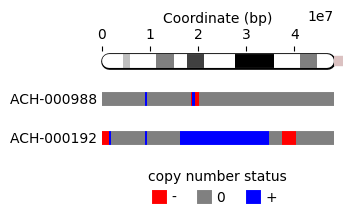

In [9]:
fig,ax=plt.subplots(
    figsize=[3,1.5],
)
_=plot_ranges(
    data=data.sort_values('sample name'),
    col_id='sample id',
    col_label='sample name',
    hue='copy number status',
    col_start='start',
    col_end='end',
    # col_sortby='sample name',
    kind='joined',
    start=0,end=48200001,
    cytobands=cytobands,
    colors={'-':'r','0':'gray','+':'b'},
    show_segments=False,
    ax=ax,
    test=False,
    )
plt.savefig(f"{output_dir_path}/ranges_joined.png",bbox_inches='tight')

#### Show numerical values 

INFO:root:shape = (1, 9) 


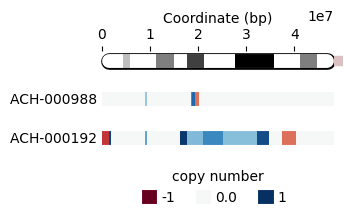

In [10]:
fig,ax=plt.subplots(
    figsize=[3,1.5],
)
_=plot_ranges(
    data=data.sort_values('sample name'),
    col_id='sample id',
    col_label='sample name',
    hue='copy number',
    col_start='start',
    col_end='end',
    # col_sortby='sample name',
    kind='joined',
    start=0,end=48200001,
    cytobands=cytobands,    
    palette='RdBu', ## colormap
    hue_lim=[-1,1], ## limits on values shown
    show_segments=False,
    ax=ax,
    test=False,
    )
plt.savefig(f"{output_dir_path}/ranges_joined_numerical.png",bbox_inches='tight')

### `split` layout

INFO:root:shape = (1, 9) 


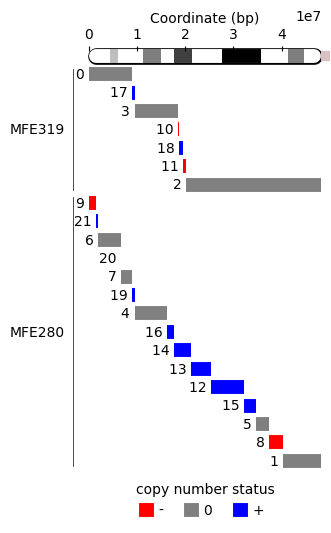

In [11]:
fig,ax=plt.subplots(
    figsize=[3,len(data)*0.25],
)
_=plot_ranges(
    data=data.sort_values(['sample id','start'],ascending=[True,False]),
    col_id='segment id',
    hue='copy number status',
    col_start='start',
    col_end='end',
    # col_sortby=['sample id','start'],
    col_groupby='sample name',
    start=0,end=48200001,
    cytobands=cytobands,
    colors={'-':'r','0':'gray','+':'b'},
    show_segments=False,
    ax=ax,
    )
plt.savefig(f"{output_dir_path}/ranges_split.png",bbox_inches='tight')

#### Show numerical values 

INFO:root:shape = (1, 9) 


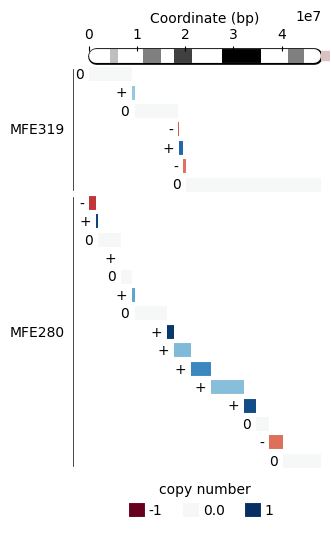

In [12]:
fig,ax=plt.subplots(
    figsize=[3,len(data)*0.25],
)
_=plot_ranges(
    data=data.sort_values(['sample id','start'],ascending=[True,False]),
    col_id='segment id',
    hue='copy number',
    col_start='start',
    col_end='end',
    # col_sortby=['sample id','start'],
    col_groupby='sample name',
    start=0,end=48200001,
    cytobands=cytobands,   
    palette='RdBu', ## colormap
    hue_lim=[-1,1], ## limits on values shown
    show_segments=False,
    col_label='copy number status',
    ax=ax,
    test=False,
    )
plt.savefig(f"{output_dir_path}/ranges_split_numerical.png",bbox_inches='tight')

## Outputs

In [13]:
import nbdev
nbdev.export.nb_export(
    **kws_nb_export
)

/home/rdandage/Documents/work/chrov/.venv/lib/python3.10/site-packages/nbdev/doclinks.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib
